# LDA Analysis

Inspiration: 
https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://medium.com/@nqabell89/visualizing-unsupervised-text-classification-output-with-pyldavis-370c1784ed58

## Imports and Setup

In [59]:
import pandas as pd

# Import the gensim LDA libraries
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

# Load the regular expression library
import re
# Load the visualization libraries
import pickle
import pyLDAvis
import pyLDAvis.gensim
from pprint import pprint

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacobrubin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [138]:
df = pd.read_csv('../Data/Questions_Final.csv')

# Uncomment if only want to run LDA for CMNI
df = df[df["Scale"] == "Conformity to Masculine Norms Inventory"]

df.shape

(94, 7)

In [132]:
# Put reviews in a list
papers = df
questionList = df['Question Text'].to_list()

In [133]:
# Remove punctuation
papers['paper_text_processed'] = \
papers['Question Text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

<>:3: DeprecationWarning: invalid escape sequence '\.'
<>:3: DeprecationWarning: invalid escape sequence '\.'
/var/folders/_8/9329lmdd2ws1z0fw87m007j80000gn/T/ipykernel_44105/2615434427.py:3: DeprecationWarning: invalid escape sequence '\.'
  papers['Question Text'].map(lambda x: re.sub('[,\.!?]', '', x))


0              it is best to keep your emotions hidden
1                in general‚ i will do anything to win
2    if i could‚ i would frequently change sexual p...
3    if there is going to be violence‚ i find a way...
4    it is important to me that people think i am h...
Name: paper_text_processed, dtype: object

## Basic LDA Model

In [139]:
# We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.
stop_words = stopwords.words('english')
#stop_words.extend(['man', 'men', 'guy', 'boy', 'guys', 'boys'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)

In [140]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### Calculate Coherence Score

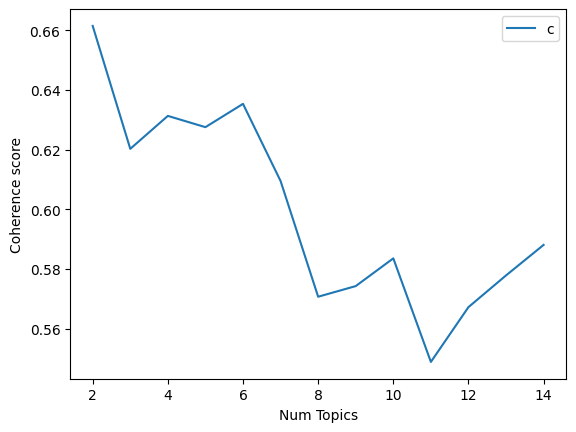

In [141]:
# see what the highest coherence is for number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=15, step=1)

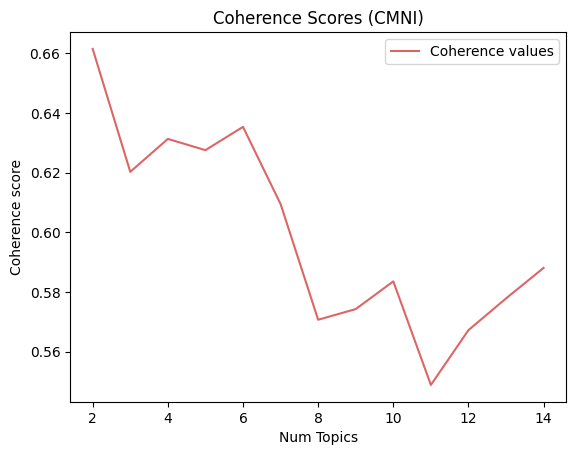

In [152]:
# Show graph
limit=15; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values, color="#dc6666", label='Coherence values')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.title("Coherence Scores (CMNI)")
plt.savefig('../Visualizations/CMNI_LDA_coherence.png', dpi=100)
plt.show()

In [148]:
# indexing at four with 6 topics
best_result_index = coherence_values.index(0.6353462548818053)
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score 
of {coherence_values[best_result_index]}''')

The 6 topics gives the highest coherence score 
of 0.6353462548818053


In [166]:
# Convert the list of tuples into a DataFrame
lda_topics = pd.DataFrame(model_topics, columns=['Topic', 'Most Relevant Words'])

# Export the DataFrame to a CSV file
lda_topics.to_csv('../Data/CMNI_LDA_topics.csv', index=False)


### Calculate Perplexity Score

In [153]:
perplexity = lda_model.log_perplexity(corpus)
perplexity

-13.807792045683136

In [167]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.103492  0.100375       1        1  20.726700
0     -0.046835 -0.041983       2        1  17.028259
2     -0.003297 -0.082214       3        1  16.839306
3     -0.037128  0.087518       4        1  15.212346
5     -0.118414  0.012999       5        1  15.168805
4      0.102181 -0.076695       6        1  15.024584, topic_info=          Term      Freq     Total Category  logprob  loglift
30        work  6.000000  6.000000  Default  30.0000  30.0000
19   important  8.000000  8.000000  Default  29.0000  29.0000
59       never  5.000000  5.000000  Default  28.0000  28.0000
53    feelings  6.000000  6.000000  Default  27.0000  27.0000
63     thought  4.000000  4.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
56        take  0.786881  3.501575   Topic6  -4.2896   0.4026
79        sure  0.786805  2.074696   Topic6  -4.2897   0.9259
130         ha  0.786743  2.745379   Topic6  -4.2898   0.6457
125     better  0.786696  2.074738   Topic6  -4.2899   0.9257
132       ving  0.786607  2.745359   Topic6  -4.2900   0.6455

[296 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
28        5  0.726865  absorbed
154       6  0.734628       act
109       4  0.730073    action
142       5  0.726864    almost
4         1  0.714475  anything
...     ...       ...       ...
12        2  0.209106     would
12        3  0.313658     would
12        4  0.209106     would
12        5  0.104553     would
12        6  0.104553     would

[282 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 6, 5])

In [168]:
# Save the visualization to an HTML file
pyLDAvis.save_html(p, '../Visualizations/CMNI_LDA_intertopic_map.html')